# 辽宁高速公路裂缝检测

In [1]:
%matplotlib inline

In [2]:
!pip install gluoncv

    100% |████████████████████████████████| 696kB 26.3MB/s ta 0:00:01
    100% |████████████████████████████████| 61kB 33.0MB/s ta 0:00:01
You are using pip version 10.0.1, however version 20.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


# 准备数据

In [3]:
from my_coco_instance import MyCOCOInstance

In [6]:
train_dataset = MyCOCOInstance(root='~/SageMaker/DatalabDataset/train', splits='annotations')
val_dataset = MyCOCOInstance(root='~/SageMaker/DatalabDataset/val', splits='annotations',skip_empty=False)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [7]:
print('Training images:', len(train_dataset))
print('Validation images:', len(val_dataset))

Training images: 41
Validation images: 56


In [8]:
print(train_dataset[6])

(
[[[121 121 121]
  [123 123 123]
  [124 124 124]
  ...
  [ 71  71  71]
  [ 70  70  70]
  [ 70  70  70]]

 [[138 138 138]
  [130 130 130]
  [119 119 119]
  ...
  [ 77  77  77]
  [ 77  77  77]
  [ 78  78  78]]

 [[126 126 126]
  [144 144 144]
  [149 149 149]
  ...
  [ 78  78  78]
  [ 79  79  79]
  [ 80  80  80]]

 ...

 [[133 133 133]
  [145 145 145]
  [158 158 158]
  ...
  [ 72  72  72]
  [ 80  80  80]
  [ 97  97  97]]

 [[148 148 148]
  [155 155 155]
  [147 147 147]
  ...
  [ 63  63  63]
  [ 72  72  72]
  [ 92  92  92]]

 [[157 157 157]
  [161 161 161]
  [139 139 139]
  ...
  [ 61  61  61]
  [ 72  72  72]
  [ 94  94  94]]]
<NDArray 2048x3040x3 @cpu(0)>, array([[  12.,  160., 3027.,  921.,    0.]], dtype=float32), [[array([[  12.  ,  160.  ],
       [  32.99,  174.98],
       [  50.98,  187.  ],
       [  74.97,  202.01],
       [ 119.99,  217.  ],
       [ 134.97,  220.  ],
       [ 164.97,  220.  ],
       [ 189.  ,  213.99],
       [ 200.98,  213.99],
       [ 230.98,  223.  ],
    

In [9]:
train_image, train_label, train_segm = train_dataset[0]
bboxes = train_label[:, :4]
cids = train_label[:, 4:5]
print('image:', train_image.shape)
print('bboxes:', bboxes.shape, 'class ids:', cids.shape)
# segm is a list of polygons which are arrays of points on the object boundary
print('masks', [[poly.shape for poly in polys] for polys in train_segm])

image: (2048, 3040, 3)
bboxes: (1, 4) class ids: (1, 1)
masks [[(103, 2)]]


# 查看标注数据

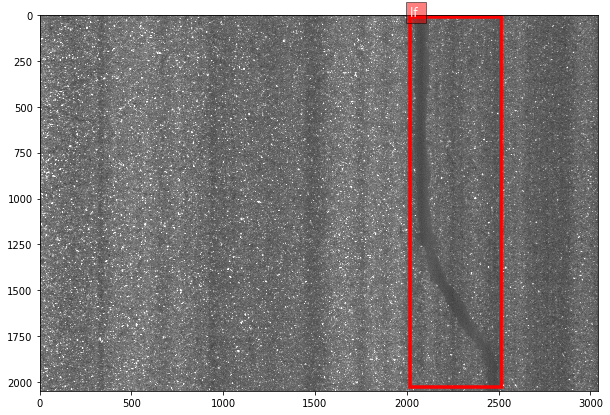

In [10]:
from matplotlib import pyplot as plt
from gluoncv.utils import viz

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)
ax = viz.plot_bbox(train_image, bboxes, labels=cids, class_names=train_dataset.classes, ax=ax)
plt.show()

In [11]:
import numpy as np
from gluoncv.data.transforms import mask as tmask

width, height = train_image.shape[1], train_image.shape[0]
train_masks = np.stack([tmask.to_mask(polys, (width, height)) for polys in train_segm])
plt_image = viz.plot_mask(train_image, train_masks)

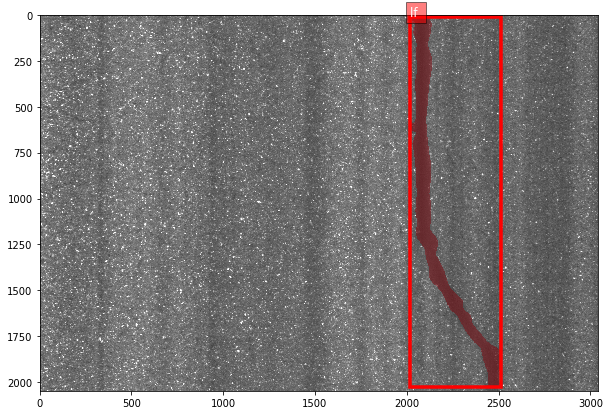

In [12]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)
ax = viz.plot_bbox(plt_image, bboxes, labels=cids, class_names=train_dataset.classes, ax=ax)
plt.show()

In [13]:
from gluoncv.data.transforms import presets
from gluoncv import utils
from mxnet import nd

In [14]:
short, max_size = 600, 1000  # resize image to short side 600 px, but keep maximum length within 1000
train_transform = presets.rcnn.MaskRCNNDefaultTrainTransform(short, max_size)
val_transform = presets.rcnn.MaskRCNNDefaultValTransform(short, max_size)

In [15]:
utils.random.seed(233)  # fix seed in this tutorial

In [16]:
train_image2, train_label2, train_masks2 = train_transform(train_image, train_label, train_segm)
print('tensor shape:', train_image2.shape)
print('box and id shape:', train_label2.shape)
print('mask shape', train_masks2.shape)

tensor shape: (3, 600, 891)
box and id shape: (1, 5)
mask shape (1, 600, 891)


In [17]:
plt_image2 = train_image2.transpose((1, 2, 0)) * nd.array((0.229, 0.224, 0.225)) + nd.array(
    (0.485, 0.456, 0.406))
plt_image2 = (plt_image2 * 255).asnumpy().astype('uint8')

The transform already converted polygons to masks and we plot them directly.



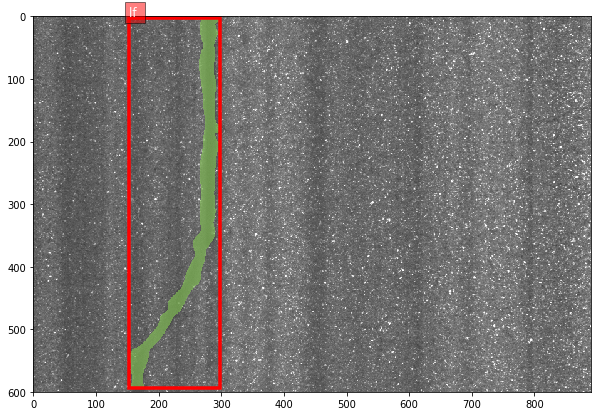

In [18]:
width, height = plt_image2.shape[1], plt_image2.shape[0]
plt_image2 = viz.plot_mask(plt_image2, train_masks2)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)
ax = viz.plot_bbox(plt_image2, train_label2[:, :4],
                   labels=train_label2[:, 4:5],
                   class_names=train_dataset.classes,
                   ax=ax)
plt.show()

# 准备加载数据



In [19]:
from gluoncv.data.batchify import Tuple, Append, MaskRCNNTrainBatchify
from mxnet.gluon.data import DataLoader

batch_size = 2  # for tutorial, we use smaller batch-size
num_workers = 0  # you can make it larger(if your CPU has more cores) to accelerate data loading

train_bfn = Tuple(*[Append() for _ in range(3)])
train_loader = DataLoader(train_dataset.transform(train_transform), batch_size, shuffle=True,
                          batchify_fn=train_bfn, last_batch='rollover', num_workers=num_workers)
val_bfn = Tuple(*[Append() for _ in range(2)])
val_loader = DataLoader(val_dataset.transform(val_transform), batch_size, shuffle=False,
                        batchify_fn=val_bfn, last_batch='keep', num_workers=num_workers)

for ib, batch in enumerate(train_loader):
    if ib > 3:
        break
    print('data 0:', batch[0][0].shape, 'label 0:', batch[1][0].shape, 'mask 0:', batch[2][0].shape)
    print('data 1:', batch[0][1].shape, 'label 1:', batch[1][1].shape, 'mask 1:', batch[2][1].shape)

data 0: (1, 3, 600, 891) label 0: (1, 1, 5) mask 0: (1, 1, 600, 891)
data 1: (1, 3, 600, 891) label 1: (1, 1, 5) mask 1: (1, 1, 600, 891)
data 0: (1, 3, 600, 891) label 0: (1, 1, 5) mask 0: (1, 1, 600, 891)
data 1: (1, 3, 600, 891) label 1: (1, 1, 5) mask 1: (1, 1, 600, 891)
data 0: (1, 3, 600, 891) label 0: (1, 1, 5) mask 0: (1, 1, 600, 891)
data 1: (1, 3, 600, 891) label 1: (1, 1, 5) mask 1: (1, 1, 600, 891)
data 0: (1, 3, 600, 891) label 0: (1, 1, 5) mask 0: (1, 1, 600, 891)
data 1: (1, 3, 600, 891) label 1: (1, 1, 5) mask 1: (1, 1, 600, 891)


# Mask RCNN Network



In [20]:
from gluoncv import model_zoo

net = model_zoo.get_model('mask_rcnn_resnet50_v1b_coco', pretrained_base=False)
print(net)

MaskRCNN(
  (features): HybridSequential(
    (0): Conv2D(None -> 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=True, in_channels=64)
    (2): Activation(relu)
    (3): MaxPool2D(size=(3, 3), stride=(2, 2), padding=(1, 1), ceil_mode=False, global_pool=False, pool_type=max, layout=NCHW)
    (4): HybridSequential(
      (0): BottleneckV1b(
        (conv1): Conv2D(None -> 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=True, in_channels=64)
        (relu1): Activation(relu)
        (conv2): Conv2D(None -> 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=True, in_channels=64)
        (relu2): Activation(relu)
        (conv3): Conv2D(None -> 256, kernel_size=(1, 1), stride=(1, 1), bia

In [21]:
import mxnet as mx

x = mx.nd.zeros(shape=(1, 3, 600, 800))
net.initialize()
cids, scores, bboxes, masks = net(x)

In [22]:
from mxnet import autograd

with autograd.train_mode():
    # this time we need ground-truth to generate high quality roi proposals during training
    gt_box = mx.nd.zeros(shape=(1, 1, 4))
    gt_label = mx.nd.zeros(shape=(1, 1, 1))
    cls_pred, box_pred, mask_pred, roi, samples, matches, rpn_score, rpn_box, anchors, \
    cls_targets, box_targets, box_masks, indices = net(x, gt_box, gt_label)

In [23]:
# the loss to penalize incorrect foreground/background prediction
rpn_cls_loss = mx.gluon.loss.SigmoidBinaryCrossEntropyLoss(from_sigmoid=False)
# the loss to penalize inaccurate anchor boxes
rpn_box_loss = mx.gluon.loss.HuberLoss(rho=1 / 9.)  # == smoothl1
# the loss to penalize incorrect classification prediction.
rcnn_cls_loss = mx.gluon.loss.SoftmaxCrossEntropyLoss()
# and finally the loss to penalize inaccurate proposals
rcnn_box_loss = mx.gluon.loss.HuberLoss()  # == smoothl1
# the loss to penalize incorrect segmentation pixel prediction
rcnn_mask_loss = mx.gluon.loss.SigmoidBinaryCrossEntropyLoss(from_sigmoid=False)

In [24]:
train_transform = presets.rcnn.MaskRCNNDefaultTrainTransform(short, max_size, net)
# return images, labels, masks, rpn_cls_targets, rpn_box_targets, rpn_box_masks loosely
batchify_fn = MaskRCNNTrainBatchify(net)
# For the next part, we only use batch size 1
batch_size = 1
train_loader = DataLoader(train_dataset.transform(train_transform), batch_size, shuffle=True,
                          batchify_fn=batchify_fn, last_batch='rollover', num_workers=num_workers)

In [25]:
for ib, batch in enumerate(train_loader):
    if ib > 0:
        break
    with autograd.train_mode():
        for data, label, masks, rpn_cls_targets, rpn_box_targets, rpn_box_masks in zip(*batch):
            label = label.expand_dims(0)
            gt_label = label[:, :, 4:5]
            gt_box = label[:, :, :4]
            # network forward
            cls_pred, box_pred, mask_pred, roi, samples, matches, rpn_score, rpn_box, anchors, \
            cls_targets, box_targets, box_masks, indices = \
                net(data.expand_dims(0), gt_box, gt_label)

            # generate targets for mask head
            roi = mx.nd.concat(
                *[mx.nd.take(roi[i], indices[i]) for i in range(indices.shape[0])], dim=0) \
                .reshape((indices.shape[0], -1, 4))
            m_cls_targets = mx.nd.concat(
                *[mx.nd.take(cls_targets[i], indices[i]) for i in range(indices.shape[0])], dim=0) \
                .reshape((indices.shape[0], -1))
            matches = mx.nd.concat(
                *[mx.nd.take(matches[i], indices[i]) for i in range(indices.shape[0])], dim=0) \
                .reshape((indices.shape[0], -1))
            mask_targets, mask_masks = net.mask_target(roi, masks.expand_dims(0), matches,
                                                       m_cls_targets)

            print('data:', data.shape)
            # box and class labels
            print('box:', gt_box.shape)
            print('label:', gt_label.shape)
            # -1 marks ignored label
            print('rpn cls label:', rpn_cls_targets.shape)
            # mask out ignored box label
            print('rpn box label:', rpn_box_targets.shape)
            print('rpn box mask:', rpn_box_masks.shape)
            # rcnn does not have ignored label
            print('rcnn cls label:', cls_targets.shape)
            # mask out ignored box label
            print('rcnn box label:', box_targets.shape)
            print('rcnn box mask:', box_masks.shape)
            print('rcnn mask label:', mask_targets.shape)
            print('rcnn mask mask:', mask_masks.shape)

data: (3, 600, 891)
box: (1, 1, 4)
label: (1, 1, 1)
rpn cls label: (1, 31920)
rpn box label: (1, 31920, 4)
rpn box mask: (1, 31920, 4)
rcnn cls label: (1, 128)
rcnn box label: (1, 32, 80, 4)
rcnn box mask: (1, 32, 80, 4)
rcnn mask label: (1, 32, 80, 14, 14)
rcnn mask mask: (1, 32, 80, 14, 14)


# 训练环节


In [27]:
for ib, batch in enumerate(train_loader):
    if ib > 0:
        break
    with autograd.record():
        for data, label, masks, rpn_cls_targets, rpn_box_targets, rpn_box_masks in zip(*batch):
            label = label.expand_dims(0)
            gt_label = label[:, :, 4:5]
            gt_box = label[:, :, :4]
            # network forward
            cls_preds, box_preds, mask_preds, roi, samples, matches, rpn_score, rpn_box, anchors, \
                cls_targets, box_targets, box_masks, indices = \
                net(data.expand_dims(0), gt_box, gt_label)

            # generate targets for mask head
            roi = mx.nd.concat(
                *[mx.nd.take(roi[i], indices[i]) for i in range(indices.shape[0])], dim=0) \
                .reshape((indices.shape[0], -1, 4))
            m_cls_targets = mx.nd.concat(
                *[mx.nd.take(cls_targets[i], indices[i]) for i in range(indices.shape[0])], dim=0) \
                .reshape((indices.shape[0], -1))
            matches = mx.nd.concat(
                *[mx.nd.take(matches[i], indices[i]) for i in range(indices.shape[0])], dim=0) \
                .reshape((indices.shape[0], -1))
            mask_targets, mask_masks = net.mask_target(roi, masks.expand_dims(0), matches,
                                                       m_cls_targets)

            # losses of rpn
            rpn_score = rpn_score.squeeze(axis=-1)
            num_rpn_pos = (rpn_cls_targets >= 0).sum()
            rpn_loss1 = rpn_cls_loss(rpn_score, rpn_cls_targets,
                                     rpn_cls_targets >= 0) * rpn_cls_targets.size / num_rpn_pos
            rpn_loss2 = rpn_box_loss(rpn_box, rpn_box_targets,
                                     rpn_box_masks) * rpn_box.size / num_rpn_pos

            # losses of rcnn
            num_rcnn_pos = (cls_targets >= 0).sum()
            rcnn_loss1 = rcnn_cls_loss(cls_preds, cls_targets,
                                       cls_targets >= 0) * cls_targets.size / cls_targets.shape[
                             0] / num_rcnn_pos
            rcnn_loss2 = rcnn_box_loss(box_preds, box_targets, box_masks) * box_preds.size / \
                         box_preds.shape[0] / num_rcnn_pos

            # loss of mask
            mask_loss = rcnn_mask_loss(mask_preds, mask_targets, mask_masks) * mask_targets.size / \
                        mask_targets.shape[0] / mask_masks.sum()

        # some standard gluon training steps:
        autograd.backward([rpn_loss1, rpn_loss2, rcnn_loss1, rcnn_loss2, mask_loss])
        trainer.step(batch_size)

NameError: name 'trainer' is not defined